### Generate a forcing data file

In [1]:
%matplotlib inline 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

import seaborn as sns
sns.set()

#### Read a World Ocean Database (WOD) nc file (rectangle near to the eastern part of the Wadden Sea) which is produced by Ocean Data Viewer (ODV) and smooth through years for depths less then 11 m, var1 is depth

We use data from the top layer for all layers ( < 11m) since there are not enough data in other layers (checked in the 1st notebook)

In [2]:
ds = xr.open_dataset('wadden_sea.nc')
df = ds.to_dataframe()
df = df[(df.date_time > '2000-01-01 00:00:00.0') & (df.var1 < 11)]
df = df[['longitude', 'latitude', 'date_time'
        ,'var1', 'var2', 'var3', 'var4', 'var5', 'var6', 'var7'
        ,'var8', 'var9', 'var10', 'var11', 'var12', 'var13', 'var14']]
df.columns = ['longitude', 'latitude', 'date_time'
             ,'Depth', 'Temperature', 'Salinity', 'Oxygen', 'Phosphate', 'Silicate', 'Nitrate'
             ,'Nitrite', 'pH', 'Chlorophyll a', 'Plankton biomass', 'Alkalinity', 'NO2+NO3', 'pCO2']
df['Oxygen'] = df['Oxygen']*44.661 # 1 ml/l = 10^3/22.391 = 44.661 μmol/l
df['Day of year'] = df.date_time.dt.dayofyear.values

#### Make a mean year from a range of 11 years

In [3]:
dfyear = df[(df.date_time > '2000-01-01 00:00:00.0') & (df.date_time < '2011-01-01 00:00:00.0')]
dfyear = dfyear.groupby(['Day of year']).mean()
dfyear = dfyear.reindex(index=range(1,366))

In [4]:
dfyear = dfyear.interpolate(method='linear',limit_direction='forward')
dfyear.loc[0:16,:] = dfyear[-1:].values
dfyear.loc[0:16,'Chlorophyll a'] = 0
dfyear = dfyear.interpolate(method='linear',limit_direction='both')
dfyear = dfyear.rolling(window=16).mean()
dfyear = dfyear.interpolate(method='linear',limit_direction='both')

#### Make three successive years from one and plot. Other parameters also will be produced for 3 succesive similar years to construct a nc file with input data for a fortran model which resolves water and sediments domains

In [5]:
df3years = dfyear.append([dfyear, dfyear])
df3years.index = range(1, len(df3years)+1)
df3years.index.name = "day"

#### Plot dfyear, just visualization

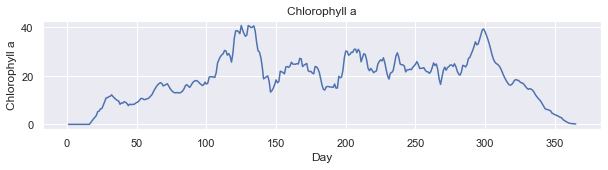

In [6]:
name = 'Chlorophyll a'
plt.plot(dfyear.index, dfyear[name]); plt.gcf().set_size_inches(10,2);
plt.title(name); plt.xlabel('Day'); plt.ylabel(name);

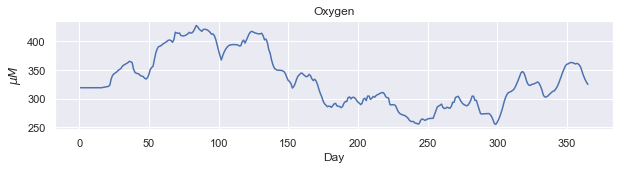

In [7]:
name = 'Oxygen'
plt.plot(dfyear.index, dfyear[name]); plt.gcf().set_size_inches(10,2);
plt.title(name); plt.xlabel('Day'); plt.ylabel('$\mu M$');

#### Generate PAR

In [8]:
# use a function described in utilities.py to generate a theoretical PAR
import utilities as ut
par_generated = np.zeros(365)
par_generated[:] = [ut.surface_radiation(x, 54) for x in range(365)]

In [9]:
par3years_generated = np.concatenate((par_generated, par_generated, par_generated), axis=None)

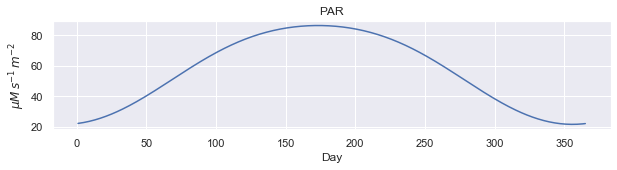

In [10]:
# visualize calculated PAR
name = 'PAR'; plt.plot(dfyear.index, par_generated);
plt.gcf().set_size_inches(10,2); plt.title(name);
plt.xlabel('Day'); plt.ylabel('$\mu M\,s^{-1}\,m^{-2}$');

#### Get data from the Wadden Sea case

In [11]:
ds = xr.open_dataset('data/wadden_sea/5_po75-25_di10e-9/water.nc')

In [12]:
dic_df = ds['B_C_DIC'].to_dataframe()
alk_df = ds['B_C_Alk'].to_dataframe()
so4_df = ds['B_S_SO4'].to_dataframe()
dic_surface_ws = dic_df.groupby('z').get_group(0.625)
alk_surface_ws = alk_df.groupby('z').get_group(0.625)
so4_surface_ws = so4_df.groupby('z').get_group(0.625)

In [13]:
dic_surface_ws.describe()

,B_C_DIC
count,1095.000000
mean,2307.395508
std,111.738174
min,1942.956665
25%,2306.509888
50%,2336.302246
75%,2361.329712
max,2442.804932


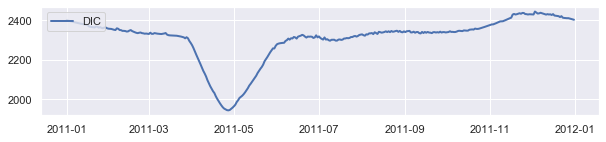

In [14]:
dic_surface_ws_year = dic_surface_ws.loc['2011-01-01':'2011-12-31']
dic_surface_ws_year = dic_surface_ws_year.reset_index();
fig = plt.figure(figsize=(10, 2)); ax = fig.add_subplot(1, 1, 1);
ax.plot(dic_surface_ws_year['time'], dic_surface_ws_year['B_C_DIC'], linewidth=2, label=r'DIC');
ax.legend(loc='upper left'); ax.grid(True);

In [15]:
alk_surface_ws.describe()

,B_C_Alk
count,1095.000000
mean,2427.692627
std,39.315445
min,2367.385498
25%,2390.409180
50%,2428.786133
75%,2463.833496
max,2487.483154


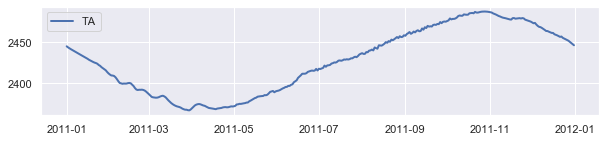

In [16]:
alk_surface_ws_year = alk_surface_ws.loc['2011-01-01':'2011-12-31']
alk_surface_ws_year = alk_surface_ws_year.reset_index();
fig = plt.figure(figsize=(10, 2)); ax = fig.add_subplot(1, 1, 1);
ax.plot(alk_surface_ws_year['time'], alk_surface_ws_year['B_C_Alk'], linewidth=2, label=r'TA');
ax.legend(loc='upper left'); ax.grid(True);

#### Get data from the North Sea base case (baseline, available after the first run) - to calculate the fluxes of TA and DIC from the WS

In [17]:
ds = xr.open_dataset('data/base/kz145_scale10000/water.nc')

In [18]:
dic_df = ds['B_C_DIC'].to_dataframe()
alk_df = ds['B_C_Alk'].to_dataframe()
so4_df = ds['B_S_SO4'].to_dataframe()
dic_surface_ns = dic_df.groupby('z').get_group(1.25)
alk_surface_ns = alk_df.groupby('z').get_group(1.25)
so4_surface_ns = so4_df.groupby('z').get_group(1.25)

In [19]:
dic_surface_ns.describe()

,B_C_DIC
count,1095.000000
mean,2112.450195
std,28.047468
min,2052.462646
25%,2099.833618
50%,2120.037842
75%,2134.926147
max,2145.429688


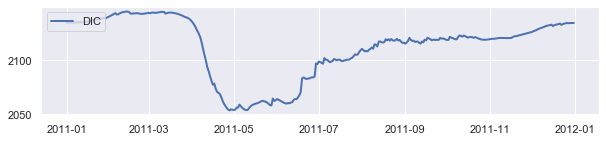

In [20]:
dic_surface_ns_year = dic_surface_ns.loc['2011-01-01':'2011-12-31']
dic_surface_ns_year = dic_surface_ns_year.reset_index();
fig = plt.figure(figsize=(10, 2)); ax = fig.add_subplot(1, 1, 1);
ax.plot(dic_surface_ns_year['time'], dic_surface_ns_year['B_C_DIC'], linewidth=2, label=r'DIC');
ax.legend(loc='upper left'); ax.grid(True);

In [21]:
alk_surface_ns.describe()

,B_C_Alk
count,1095.000000
mean,2292.449219
std,13.234084
min,2269.279541
25%,2280.860352
50%,2292.820312
75%,2307.141968
max,2307.814697


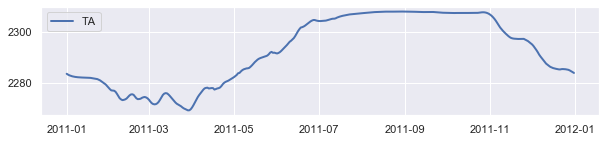

In [22]:
alk_surface_ns_year = alk_surface_ns.loc['2011-01-01':'2011-12-31']
alk_surface_ns_year = alk_surface_ns_year.reset_index();
fig = plt.figure(figsize=(10, 2)); ax = fig.add_subplot(1, 1, 1);
ax.plot(alk_surface_ns_year['time'], alk_surface_ns_year['B_C_Alk'], linewidth=2, label=r'TA');
ax.legend(loc='upper left'); ax.grid(True);

#### Generate a north_sea_out.nc file which consist of 3 successive similar years

In [23]:
import utilities as ut
import itertools as it
from netCDF4 import Dataset

rootgrp = Dataset("north_sea_out.nc", "w", format='NETCDF3_CLASSIC')

levelface = rootgrp.createDimension("levelface", 6)
levelcntr = rootgrp.createDimension("levelcntr", 5)
time = rootgrp.createDimension("time", 1095)

times = rootgrp.createVariable("time","f8",("time",))
times.units = "seconds since 2010-01-01 00:00:00.0"
times.calendar = "gregorian"

par = rootgrp.createVariable("par","f4",("time",))
par.units = "microM photons m−2 s−1"

hice = rootgrp.createVariable("hice","f4",("time",))
snowthick = rootgrp.createVariable("snowthick","f4",("time",))
icesurft = rootgrp.createVariable("icesurft","f4",("time",))

levelsface = rootgrp.createVariable("levelface","f4",("levelface",))
levelsface.units = "m"
levelscntr = rootgrp.createVariable("levelcntr","f4",("levelcntr",))
levelscntr.units = "m"
temperature = rootgrp.createVariable("temperature","f8",("time","levelcntr",))
temperature.units = "C degrees"
salinity = rootgrp.createVariable("salinity","f8",("time","levelcntr",))
salinity.units = "psu"
sigma = rootgrp.createVariable("sigma","f8",("time","levelcntr",))
sigma.units = "kg m-1"
turbulence = rootgrp.createVariable("turbulence","f8",("time","levelface",))
turbulence.units = "m2 s-1"

ammonium = rootgrp.createVariable("ammonium","f8",("time","levelcntr",))
ammonium.units = "mM N m-3"
nitrate = rootgrp.createVariable("nitrate","f8",("time","levelcntr",))
nitrate.units = "mM N m-3"
#sulfate = rootgrp.createVariable("sulfate","f8",("time","levelcntr",))
#sulfate.units = "mM S m-3"
silicate = rootgrp.createVariable("silicate","f8",("time","levelcntr",))
silicate.units = "mM Si m-3"
phosphate = rootgrp.createVariable("phosphate","f8",("time","levelcntr",))
phosphate.units = "mM P m-3"
oxygen = rootgrp.createVariable("oxygen","f8",("time","levelcntr",))
oxygen.units = "mM O2 m-3"
dic = rootgrp.createVariable("DIC","f8",("time","levelcntr",))
dic.units = "mM C m-3"
dic_in = rootgrp.createVariable("DIC_in","f8",("time","levelcntr",))
dic_in.units = "mM C m-3"
dic_in_eq = rootgrp.createVariable("DIC_in_eq","f8",("time","levelcntr",))
dic_in_eq.units = "mM C m-3"
ta = rootgrp.createVariable("TA","f8",("time","levelcntr",))
ta.units = "mM m-3"
ta_in = rootgrp.createVariable("TA_in","f8",("time","levelcntr",))
ta_in.units = "mM m-3"
ta_in_eq = rootgrp.createVariable("TA_in_eq","f8",("time","levelcntr",))
ta_in_eq.units = "mM m-3"
chl_a = rootgrp.createVariable("chl_a","f8",("time","levelcntr",))
chl_a.units = "mg Chl a"

lvlface = np.array([20, 15, 10, 5, 2.5, 0])
lvlcntr = np.array([17.5, 12.5, 7.5, 3.75, 1.25])

levelsface[:] = lvlface
levelscntr[:] = lvlcntr

In [24]:
times[:] = df3years.index.values * 24 * 60 * 60
par[:] = par3years_generated
hice[:] = 0
snowthick[:] = 0
icesurft[:] = 0

In [25]:
temperature[:,:] = np.vstack(np.tile(df3years.Temperature.values,(lvlcntr.size,1))).T
salinity[:,:]    = np.vstack(np.tile(df3years.Salinity.values,(lvlcntr.size,1))).T

Calculate eddy diffusivity, see utilities.py

In [26]:
for i in range(lvlcntr.size):
    sigma[:,i] = [ut.svan(s,t,p) for s,t,p in 
                 zip(df3years.Salinity.values, df3years.Temperature.values, it.count(lvlcntr[i]))]

In [27]:
sigmaface = np.zeros((1095,lvlface.size))

In [28]:
for i in range(lvlface.size):
    sigmaface[:,i] = [ut.svan(s,t,p) for s,t,p in 
                     zip(df3years.Salinity.values, df3years.Temperature.values, it.count(lvlface[i]))]
    turbulence[:,i] = ut.gargett(sigmaface[:,i], 1)

In [29]:
ammonium[:,:] = 0.1
nitrate[:,:] = np.vstack(np.tile(df3years.Nitrate.values,(lvlcntr.size,1))).T
silicate[:,:] = np.vstack(np.tile(df3years.Silicate.values,(lvlcntr.size,1))).T
phosphate[:,:] = np.vstack(np.tile(df3years.Phosphate.values,(lvlcntr.size,1))).T
oxygen[:,:] = np.vstack(np.tile(df3years.Oxygen.values,(lvlcntr.size,1))).T

In [30]:
#sulfate[:,:] = np.vstack((np.tile(so4_surface_ns['B_S_SO4'].values,(lvlcntr.size-1,1)), so4_surface_ws['B_S_SO4'].values)).T
#dic[:,:] = np.vstack((np.tile(dic_surface_ns['B_C_DIC'].values,(lvlcntr.size-1,1)), dic_surface_ws['B_C_DIC'].values)).T

In [31]:
ta[:,:] =  np.vstack(np.tile(alk_surface_ns['B_C_Alk'].values,(lvlcntr.size,1))).T
dic[:,:] = np.vstack(np.tile(dic_surface_ns['B_C_DIC'].values,(lvlcntr.size,1))).T
chl_a[:,:] = np.vstack(np.tile(df3years['Chlorophyll a'].values,(lvlcntr.size,1))).T

1) TA advective input calculation

In [32]:
alk_surface_ns['B_C_Alk'].mean()

2292.4492

In [33]:
alk_surface_ws['B_C_Alk'].mean()

2427.6926

a) Diff to make TA mean values equal both in WS and NS

In [34]:
alk_diff = alk_surface_ws['B_C_Alk'].mean()-alk_surface_ns['B_C_Alk'].mean()

In [35]:
alk_ws_ready = alk_surface_ws['B_C_Alk'].values-alk_diff
#alk_ns_ready = np.zeros(1095)+alk_surface_ns['B_C_Alk'].mean()
alk_ns_ready = alk_surface_ns['B_C_Alk'].values
V = 0.03; dx = 10000
ta_input_eq = -(V*alk_ns_ready - V*alk_ws_ready)/dx

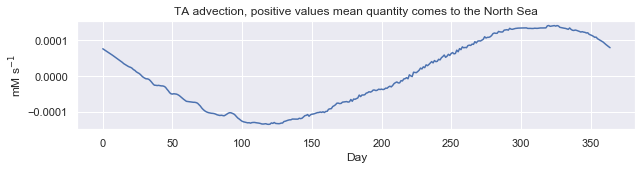

In [36]:
ox = np.arange(365); name = 'TA advection, positive values mean quantity comes to the North Sea'
plt.plot(ox, ta_input_eq[:365]); plt.gcf().set_size_inches(10,2);
plt.title(name); plt.xlabel('Day'); plt.ylabel('mM s$^{-1}$');

b) Diff to make min TA value in WS of 2250 (like in data given by J. Beusekom)

In [37]:
alk_surface_ws['B_C_Alk'].min()

2367.3855

In [38]:
alk_diff = alk_surface_ws['B_C_Alk'].min() - 2250

Calculate a flux using the WS width

In [39]:
alk_ws_ready = alk_surface_ws['B_C_Alk'].values-alk_diff
alk_ns_ready = alk_surface_ns['B_C_Alk'].values
V = 0.03; dx = 20000
ta_input = -(V*alk_ns_ready - V*alk_ws_ready)/dx

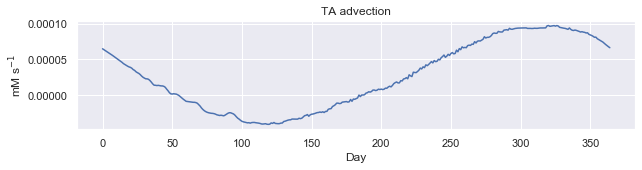

In [40]:
ox = np.arange(365); name = 'TA advection'
plt.plot(ox, ta_input[:365]); plt.gcf().set_size_inches(10,2);
plt.title(name); plt.xlabel('Day'); plt.ylabel('mM s$^{-1}$');

c) Keep the calculated means

In [41]:
#alk_ws_ready = alk_surface_ws['B_C_Alk'].values
#alk_ns_ready = alk_surface_ns['B_C_Alk'].values
#V = 0.03; dx = 20000
#ta_input = -(V*alk_ns_ready - V*alk_ws_ready)/dx

In [42]:
#ox = np.arange(365); name = 'TA advection, positive values mean quantity comes to the North Sea'
#plt.plot(ox, ta_input[:365]); plt.gcf().set_size_inches(10,2);
#plt.title(name); plt.xlabel('Day'); plt.ylabel('mM s$^{-1}$');

In [43]:
M_year_msq = sum(ta_input[:365]*60*60*24)/1000

multiply by 5 to get a total input from the WS in GM

In [44]:
M_year_msq*5

4.218084219903685

2) DIC advective input calculation

In [45]:
dic_surface_ns['B_C_DIC'].mean()

2112.4502

In [46]:
dic_surface_ws['B_C_DIC'].mean()

2307.3955

a) Assuming the same mean DIC values in WS and NS

In [47]:
dic_diff = dic_surface_ws['B_C_DIC'].mean()-dic_surface_ns['B_C_DIC'].mean()

In [48]:
dic_ws_ready = dic_surface_ws['B_C_DIC'].values-dic_diff
dic_ns_ready = dic_surface_ns['B_C_DIC'].values
V = 0.03; dx = 10000
dic_input_eq = -(V*dic_ns_ready - V*dic_ws_ready)/dx

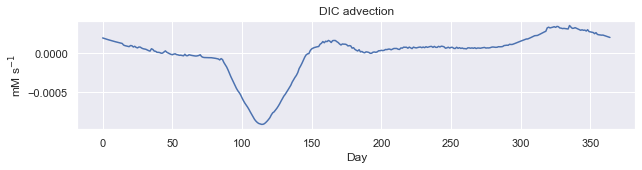

In [49]:
ox = np.arange(365); name = 'DIC advection'
plt.plot(ox, dic_input_eq[:365]); plt.gcf().set_size_inches(10,2);
plt.title(name); plt.xlabel('Day'); plt.ylabel('mM s$^{-1}$');

b) According to Brasse 1999 table 1 average DIC values in WS is approximately 100 mM higher than in NS

In [50]:
dic_diff = 90 #according to mean values in NS and WS

In [51]:
dic_ws_ready = dic_surface_ws['B_C_DIC'].values-dic_diff
dic_ns_ready = dic_surface_ns['B_C_DIC'].values
V = 0.03; dx = 20000
dic_input = -(V*dic_ns_ready - V*dic_ws_ready)/dx

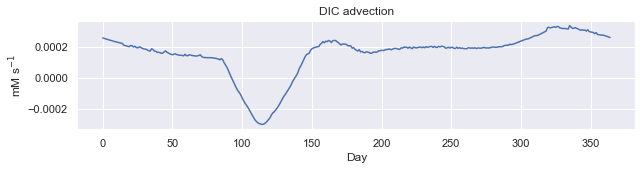

In [52]:
ox = np.arange(365); name = 'DIC advection'
plt.plot(ox, dic_input[:365]); plt.gcf().set_size_inches(10,2);
plt.title(name); plt.xlabel('Day'); plt.ylabel('mM s$^{-1}$');

In [53]:
dic_ws_ready.mean()

2217.3955

In [54]:
dic_ns_ready.mean()

2112.4502

c) Keep the means

In [55]:
#dic_ws_ready = dic_surface_ws['B_C_DIC'].values
#dic_ns_ready = dic_surface_ns['B_C_DIC'].values
#V = 0.03; dx = 20000
#dic_input = -(V*dic_ns_ready - V*dic_ws_ready)/dx

In [56]:
#ox = np.arange(365); name = 'DIC advection'
#plt.plot(ox, dic_input[:365]); plt.gcf().set_size_inches(10,2);
#plt.title(name); plt.xlabel('Day'); plt.ylabel('mM s$^{-1}$');

In [57]:
ta_in[:,:] = np.vstack((np.tile(np.zeros(1095),(lvlcntr.size-1,1)), ta_input)).T
ta_in_eq[:,:] = np.vstack((np.tile(np.zeros(1095),(lvlcntr.size-1,1)), ta_input_eq)).T
dic_in[:,:] = np.vstack((np.tile(np.zeros(1095),(lvlcntr.size-1,1)), dic_input)).T
dic_in_eq[:,:] = np.vstack((np.tile(np.zeros(1095),(lvlcntr.size-1,1)), dic_input_eq)).T

In [58]:
rootgrp.close()